Total revenue from parking before discount: ₹2773960.00
Total revenue from parking after discount: ₹2530895.00
Total revenue from shopping: ₹157431598.00
Number of lost customers due to price: 86986
Number of lost customers due to parking lot being full: 270550
Number of lost customers due to WTV below threshold: 5895
Revenue lost due to WTV below threshold: ₹85850.00
Customer Log:
   Parking Duration (mins)  Shopping Amount  Parking Charge Before Discount  \
0                    53.48             1959                            25.0   
1                    45.96             5866                            25.0   
2                    16.55                0                            15.0   
3                    66.06              628                            50.0   
4                    68.19                0                            50.0   

   Discount  Final Parking Charge    WTV  
0         0                  25.0  80.12  
1        25                   0.0  73.91  
2         0

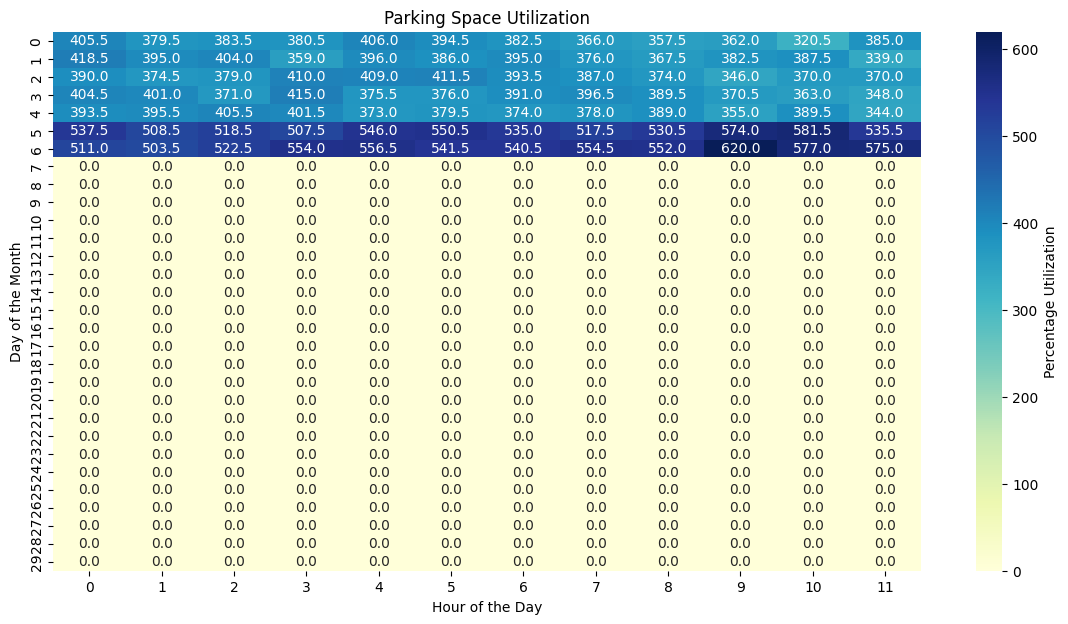

In [16]:
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Simulation parameters
SIM_DURATION = 30 * 12 * 60  # 30 days, 12 hours per day (8 AM to 8 PM)
CAPACITY = 200
WILLINGNESS_TO_VISIT = 0.80  # 80% willingness to visit (predefined threshold)
SHOPPING_PROBABILITY = 0.60  # 60% chance that a parked vehicle will shop

# Arrival rates based on the day of the week and time slots
ARRIVAL_RATES = {
    'Sunday': [(8, 12, 75), (12, 17, 250), (17, 20, 250)],
    'Monday': [(8, 12, 75), (12, 17, 250), (17, 20, 250)],
    'Tuesday': [(8, 12, 75), (12, 17, 250), (17, 20, 250)],
    'Wednesday': [(8, 12, 75), (12, 17, 250), (17, 20, 250)],
    'Thursday': [(8, 12, 75), (12, 17, 250), (17, 20, 250)],
    'Friday': [(8, 12, 100), (12, 17, 350), (17, 20, 400)],
    'Saturday': [(8, 12, 100), (12, 17, 350), (17, 20, 400)]
}

# Initialize data for tracking arrivals, inter-arrival times, parking durations, revenue, and parking space utilization
arrival_pattern = np.zeros((30, 12))  # 30 days, 12 hours per day (8 AM to 8 PM)
inter_arrival_times = [[] for _ in range(30 * 12)]  # List of lists for storing inter-arrival times for each time slot
parking_durations = []  # List to store parking durations
charges_before_discount = []  # List to store parking charges before discount
charges_after_discount = []  # List to store parking charges after discount
total_revenue_parking_before_discount = 0  # Total parking revenue before discount
total_revenue_parking_after_discount = 0  # Total parking revenue after discount
total_revenue_shopping = 0  # Total shopping revenue accumulator
lost_customers_due_to_price = 0  # Lost customers due to dissatisfaction with price
lost_customers_due_to_full = 0  # Lost customers due to parking lot being full
lost_customers_due_to_WTV = 0  # Lost customers due to WTV below threshold
parked_customers = 0  # Parked customers accumulator
spending_data = []  # List to store shopping spending
customer_log = []  # List to store detailed log of each customer
revenue_lost_due_to_WTV = 0  # Revenue lost due to WTV falling below threshold

# WTV formula parameters
x = -1.27056
y = -0.00159

# Spending parameters
mean_spending = 5000  # Mean for the exponential distribution for shopping
lambda_spending = 1 / mean_spending  # Rate parameter for the exponential distribution

def get_arrival_rate(day, hour, occupancy):
    """Return the arrival rate based on the day, hour, and occupancy."""
    base_rate = 0
    for start, end, rate in ARRIVAL_RATES[day]:
        if start <= hour < end:
            base_rate = rate
            break
    # Adjust arrival rate based on dynamic pricing
    if occupancy < 0.2:
        adjusted_rate = base_rate * 1.2  # Increase rate when occupancy is low
    elif occupancy > 0.8:
        adjusted_rate = base_rate * 0.8  # Decrease rate when occupancy is high
    else:
        adjusted_rate = base_rate
    return max(adjusted_rate, 0.01)  # Ensure non-zero arrival rate

def calculate_charge(parking_duration, discount=0):
    """Calculate the charge based on parking duration with ceiling logic and apply discount."""
    if parking_duration < 30:
        return 15 - discount
    else:
        hours = np.ceil(parking_duration / 60)  # Round up to the nearest hour
        return 25 * hours - discount  # Charge ₹25 per hour

def calculate_wtv(spending):
    """Calculate the WTV based on the shopping amount and fixed parameters."""
    return x * 25 + y * spending + 115  # WTV formula

def vehicle(env, parking_lot, day_index, hour_index, inter_arrival_time):
    """Simulates vehicle parking behavior, tracks arrivals, inter-arrival times, and calculates revenue."""
    global total_revenue_parking_before_discount, total_revenue_parking_after_discount
    global lost_customers_due_to_price, lost_customers_due_to_full, parked_customers
    global total_revenue_shopping, customer_log, lost_customers_due_to_WTV, revenue_lost_due_to_WTV
    global charges_before_discount, charges_after_discount

    # Check if the vehicle decides to park based on willingness to visit
    if np.random.random() > WILLINGNESS_TO_VISIT:
        lost_customers_due_to_price += 1
        return  # Vehicle leaves without parking
    
    with parking_lot.request() as request:
        yield request | env.timeout(0)  # Attempt to acquire a parking space

        if not request.triggered:  # If the request was not triggered, parking is full
            lost_customers_due_to_full += 1
            return  # Vehicle leaves without parking

        # Successfully parked
        parked_customers += 1

        # Generate parking duration (in minutes)
        parking_duration = np.random.exponential(60)  # Exponential distribution with mean 60 minutes
        parking_durations.append(parking_duration)  # Store parking duration

        # Calculate the parking charge before discount
        charge_before_discount = calculate_charge(parking_duration)
        charges_before_discount.append(charge_before_discount)
        total_revenue_parking_before_discount += charge_before_discount  # Update total parking revenue before discount
        
        # Determine if the customer will shop (60% chance)
        if np.random.random() >= SHOPPING_PROBABILITY:
            # Generate shopping spending based on exponential distribution
            spending = np.random.exponential(scale=mean_spending)
            spending_rounded = round(spending)
            spending_data.append(spending_rounded)
            total_revenue_shopping += spending_rounded

            # Determine discount and final parking charge
            if spending_rounded > 5000:
                if parking_duration < 30:
                    discount = 15
                else:
                    discount = 25
            else:
                discount = 0
            
            charge_after_discount = max(charge_before_discount - discount, 0)  # Ensure charge is not negative
            charges_after_discount.append(charge_after_discount)
            total_revenue_parking_after_discount += charge_after_discount  # Update total parking revenue after discount

            # Calculate WTV of the customer
            wtv_of_arrived_customer = calculate_wtv(spending_rounded)

            # If WTV is less than 70, consider the customer lost due to WTV below threshold
            if wtv_of_arrived_customer < 70:
                lost_customers_due_to_WTV += 1
                revenue_lost_due_to_WTV += charge_after_discount
                return  # Customer leaves, no parking revenue

            # Log customer details
            customer_log.append({
                'Parking Duration (mins)': round(parking_duration, 2),
                'Shopping Amount': spending_rounded,  # Rounded shopping amount
                'Parking Charge Before Discount': charge_before_discount,
                'Discount': discount,
                'Final Parking Charge': charge_after_discount,
                'WTV': round(wtv_of_arrived_customer, 2)
            })
        else:
            # If the customer does not shop, apply no discount
            discount = 0
            charge_after_discount = charge_before_discount
            charges_after_discount.append(charge_after_discount)
            total_revenue_parking_after_discount += charge_after_discount  # Update total parking revenue after discount

            # Log customer details for non-shoppers
            customer_log.append({
                'Parking Duration (mins)': round(parking_duration, 2),
                'Shopping Amount': 0,  # No shopping amount
                'Parking Charge Before Discount': charge_before_discount,
                'Discount': discount,
                'Final Parking Charge': charge_after_discount,
                'WTV': "N/A"  # Non-shoppers do not have WTV calculated
            })

        yield env.timeout(parking_duration)  # Simulate parking duration

        # Track arrivals for the specific day and hour
        arrival_pattern[day_index, hour_index] += 1
        # Store the inter-arrival time
        inter_arrival_times[day_index * 12 + hour_index].append(inter_arrival_time)

def arrival_process(env, parking_lot, day, day_index):
    """Generates vehicle arrivals for each hour of the day based on the arrival rate and occupancy."""
    global parked_customers

    while True:
        hour_index = int(env.now // 60 % 12)  # Determine the hour index
        hour = hour_index + 8  # Convert to 24-hour format
        
        # Calculate the current occupancy rate
        occupancy = parked_customers / CAPACITY  # Current occupancy rate
        arrival_rate = get_arrival_rate(day, hour, occupancy)  # Adjust arrival rate based on occupancy

        # Ensure arrival rate is not zero
        if arrival_rate <= 0:
            arrival_rate = 0.01

        # Generate inter-arrival time based on exponential distribution
        inter_arrival_time = np.random.exponential(60 / arrival_rate)
        yield env.timeout(inter_arrival_time)  # Wait for the next arrival

        env.process(vehicle(env, parking_lot, day_index, hour_index, inter_arrival_time))  # Spawn a new vehicle

def run_simulation():
    """Run the simulation for the defined duration."""
    global parked_customers
    env = simpy.Environment()

    # Initialize parking lot
    parking_lot = simpy.Resource(env, capacity=CAPACITY)

    # Schedule arrival processes for each day
    for day_index, day in enumerate(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']):
        env.process(arrival_process(env, parking_lot, day, day_index))

    env.run(until=SIM_DURATION)  # Run the simulation for the defined duration

    # Convert raw arrival counts to percentage utilization
    percentage_utilization = (arrival_pattern / (CAPACITY * 1.0)) * 100  # Convert to percentage

    # Print results
    print(f"Total revenue from parking before discount: ₹{total_revenue_parking_before_discount:.2f}")
    print(f"Total revenue from parking after discount: ₹{total_revenue_parking_after_discount:.2f}")
    print(f"Total revenue from shopping: ₹{total_revenue_shopping:.2f}")
    print(f"Number of lost customers due to price: {lost_customers_due_to_price}")
    print(f"Number of lost customers due to parking lot being full: {lost_customers_due_to_full}")
    print(f"Number of lost customers due to WTV below threshold: {lost_customers_due_to_WTV}")
    print(f"Revenue lost due to WTV below threshold: ₹{revenue_lost_due_to_WTV:.2f}")

    # DataFrame for customer logs
    customer_df = pd.DataFrame(customer_log)
    print("Customer Log:")
    print(customer_df.head())

    # Plot occupancy chart before and after dynamic pricing
    plt.figure(figsize=(14, 7))
    sns.heatmap(percentage_utilization, cmap="YlGnBu", annot=True, fmt=".1f", cbar_kws={'label': 'Percentage Utilization'})
    plt.title('Parking Space Utilization')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Day of the Month')
    plt.show()

# Run the simulation
run_simulation()
